<a href="https://colab.research.google.com/github/vnikhilesh1/html5-canvas-bird/blob/main/CMPE252_FoodImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive (optional if saving results to Google Drive)
from google.colab import drive
drive.mount('/content/drive')

# Verify GPU availability
!nvidia-smi

Mounted at /content/drive
Sat Dec 14 06:45:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              49W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------

In [2]:
# Check if TensorFlow is installed
!pip install tensorflow --upgrade

# Install OpenCV (if not installed)
!pip install opencv-python

# Importing required libraries
import tensorflow as tf
import matplotlib.image as img
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import collections
from shutil import copy, copytree, rmtree
import os
import random
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense,
    Dropout,
    Activation,
    Flatten,
    Convolution2D,
    MaxPooling2D,
    ZeroPadding2D,
    GlobalAveragePooling2D,
    AveragePooling2D,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras import models
import cv2

# Ensure TensorFlow is using GPU (if available)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if len(tf.config.experimental.list_physical_devices('GPU')) == 0:
    print("No GPU detected. Using CPU.")

# Matplotlib configuration for inline visualization
%matplotlib inline

# Checking TensorFlow version for compatibility
print("TensorFlow Version:", tf.__version__)

# Placeholder: Add dataset loading code if needed (specific to your project setup in Colab)
# For example, if using Google Drive:
# from google.colab import drive
# drive.mount('/content/drive')
# DATASET_PATH = '/content/drive/MyDrive/your_dataset_folder/'

# Additional tips:
# 1. If you plan to use a dataset, ensure it's uploaded to Google Drive or another accessible path.
# 2. Modify any file path operations to align with Colab's environment.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 113.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.
Num GPUs Available:  1
TensorFlow Version: 2.18.0


In [3]:
# Helper function to download and extract the Food-101 dataset
def get_data_extract():
    if "food-101" in os.listdir():
        print("Dataset already exists")
    else:
        print("Downloading the data...")
        # Use wget to download the dataset
        !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
        print("Dataset downloaded!")
        print("Extracting data...")
        # Extract the tar.gz file
        !tar -xzvf food-101.tar.gz
        print("Extraction done!")

# Call the function
get_data_extract()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

# Understand dataset structure and files



In [4]:
# Check the main dataset folder
!ls food-101/

# Check the contents of the 'images' subdirectory
print("Contents of 'food-101/images':")
print(os.listdir('food-101/images')[:10])  # Show first 10 entries

# Check the contents of the 'meta' subdirectory
print("\nContents of 'food-101/meta':")
print(os.listdir('food-101/meta'))

# Display the first few lines of 'train.txt' (list of training samples)
print("\nFirst few lines of 'meta/train.txt':")
!head food-101/meta/train.txt

# Display the first few lines of 'classes.txt' (list of classes)
print("\nFirst few lines of 'meta/classes.txt':")
!head food-101/meta/classes.txt

images	license_agreement.txt  meta  README.txt
Contents of 'food-101/images':
['crab_cakes', 'beef_tartare', 'french_toast', 'cannoli', 'spaghetti_carbonara', 'clam_chowder', 'chicken_curry', 'deviled_eggs', 'garlic_bread', 'steak']

Contents of 'food-101/meta':
['labels.txt', 'train.json', 'train.txt', 'classes.txt', 'test.txt', 'test.json']

First few lines of 'meta/train.txt':
apple_pie/1005649
apple_pie/1014775
apple_pie/1026328
apple_pie/1028787
apple_pie/1043283
apple_pie/1050519
apple_pie/1057749
apple_pie/1057810
apple_pie/1072416
apple_pie/1074856

First few lines of 'meta/classes.txt':
apple_pie
baby_back_ribs
baklava
beef_carpaccio
beef_tartare
beet_salad
beignets
bibimbap
bread_pudding
breakfast_burrito


# Visualize random image from each of the 101 classes

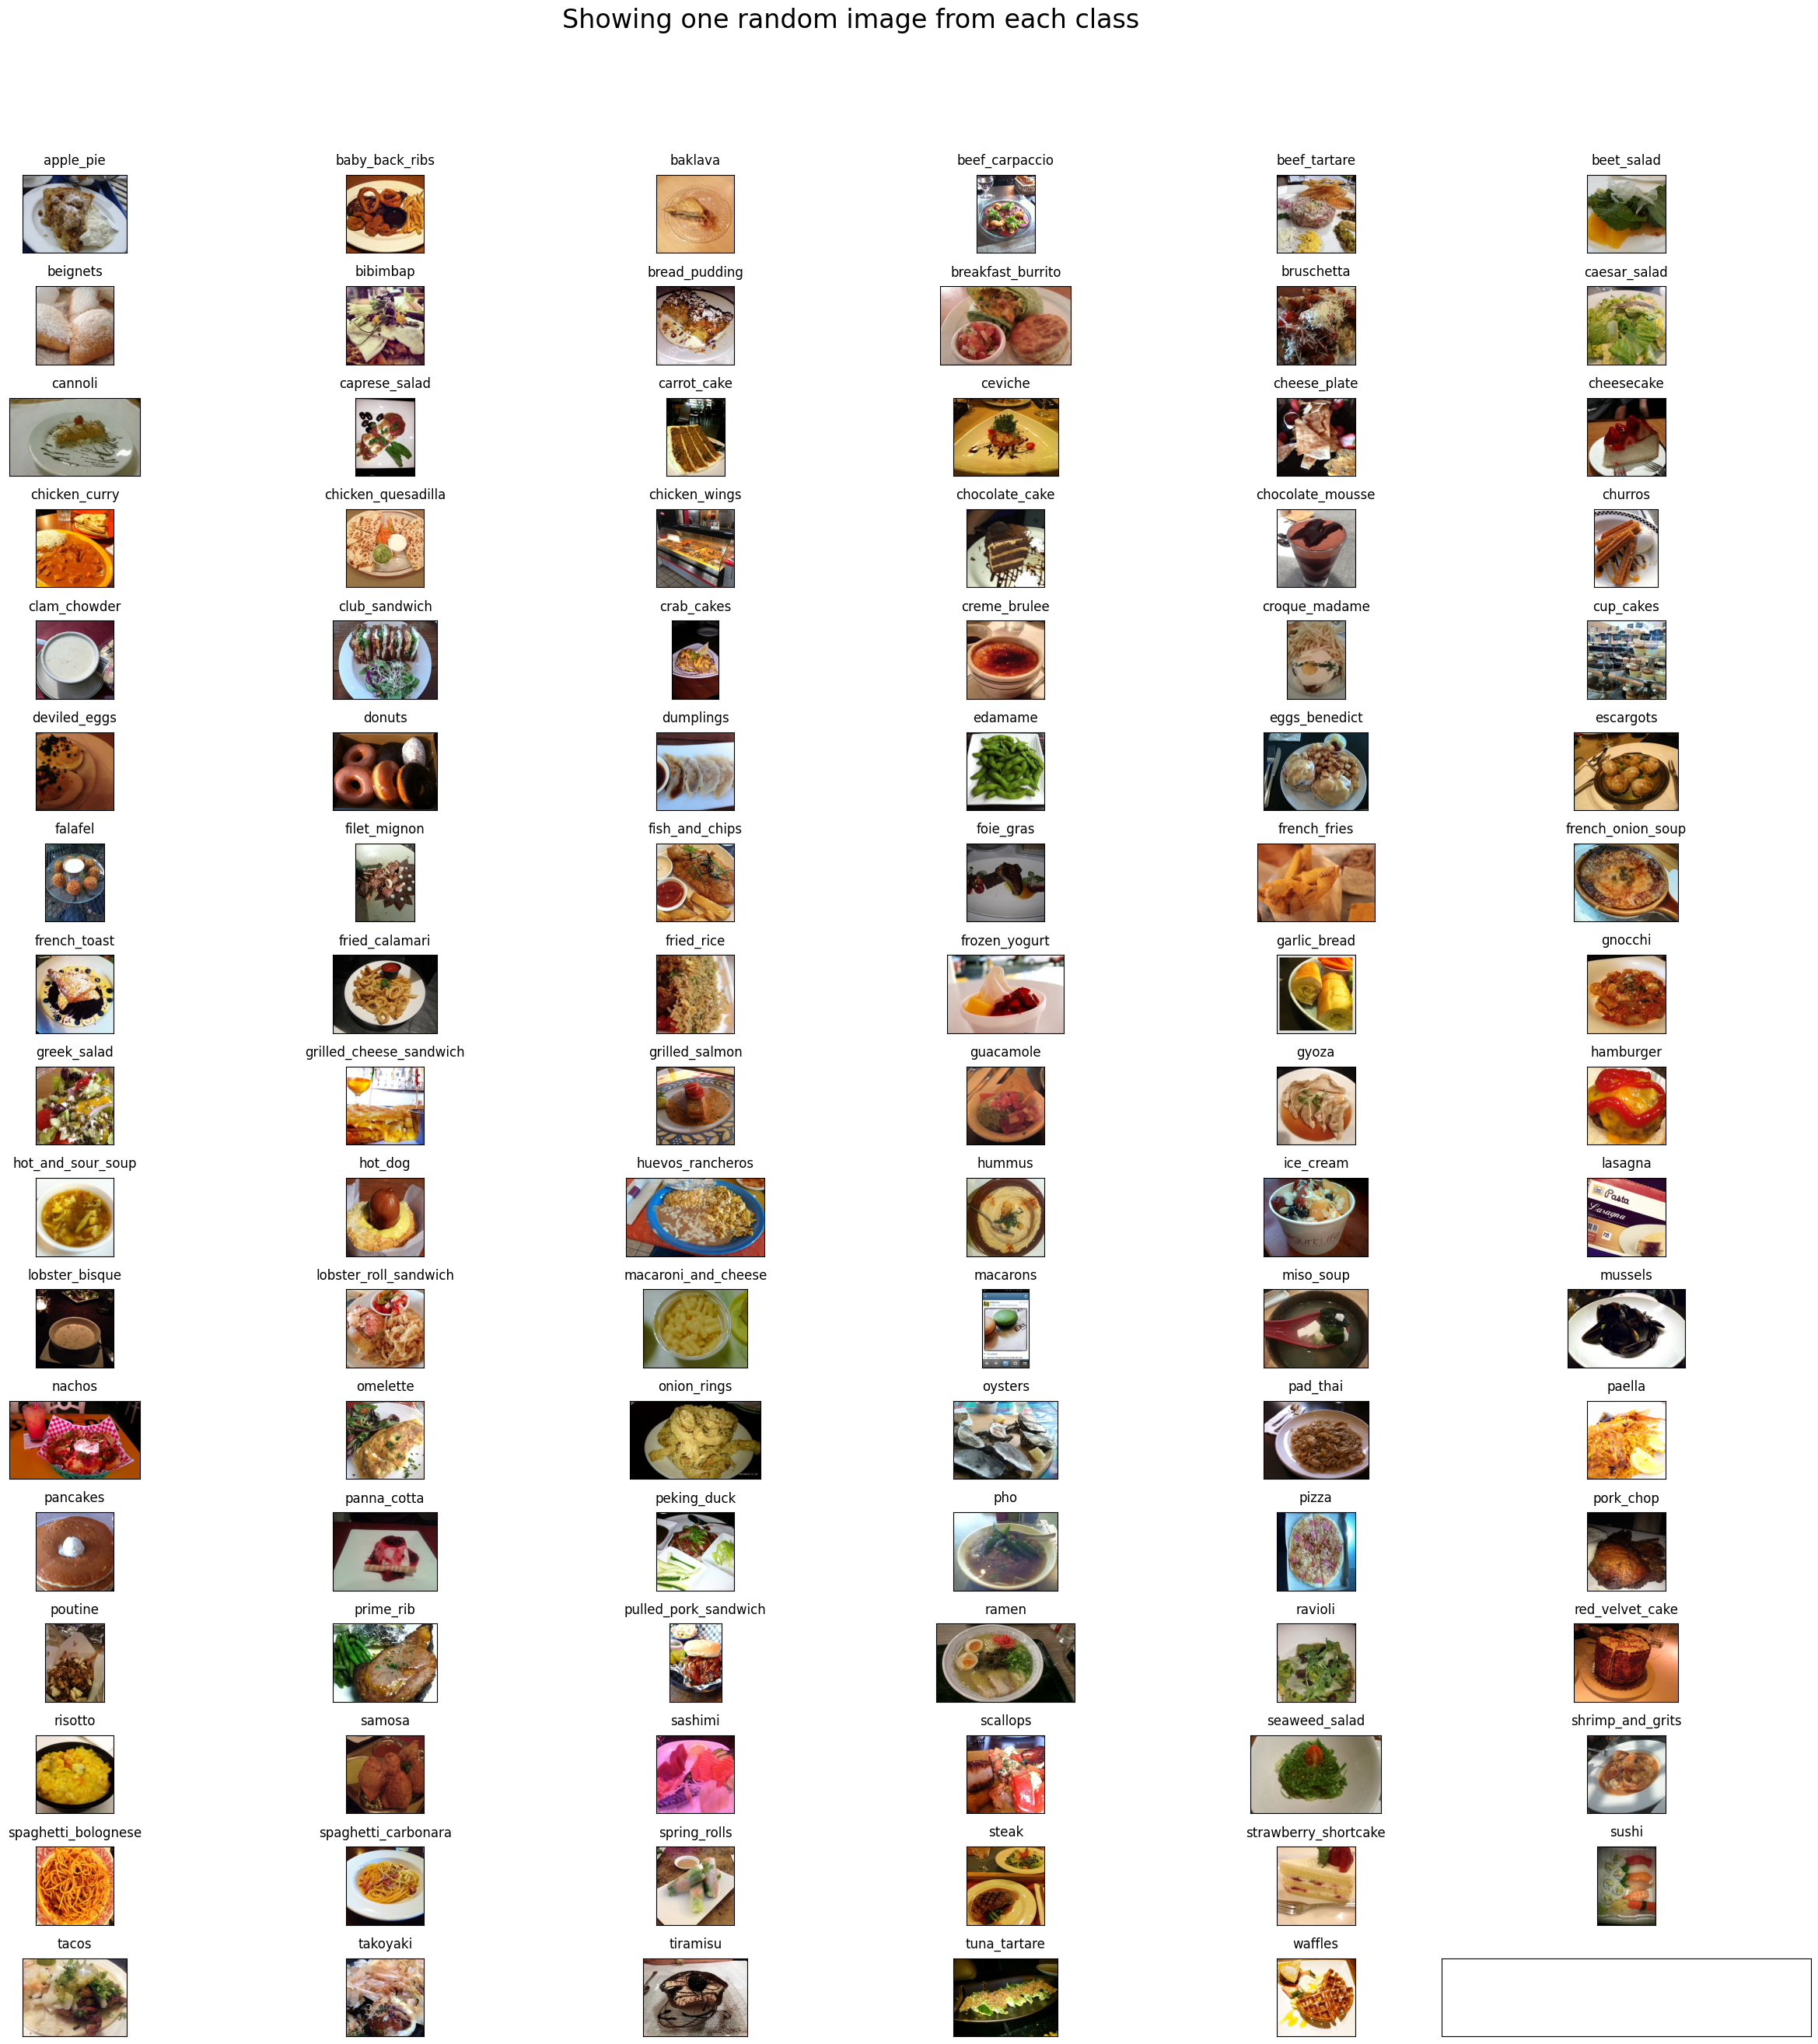

In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np

# Define the dataset directory
data_dir = "food-101/images/"

# Ensure the dataset exists before proceeding
if not os.path.exists(data_dir):
    print("Dataset not found. Please check the path or download the dataset.")
else:
    # Initialize parameters for the grid
    rows = 17
    cols = 6
    fig, ax = plt.subplots(rows, cols, figsize=(25, 25))
    fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24)

    # Get sorted list of food categories
    foods_sorted = sorted(os.listdir(data_dir))
    food_id = 0  # To track class index

    for i in range(rows):
        for j in range(cols):
            try:
                food_selected = foods_sorted[food_id]  # Get the class name
                food_id += 1
            except IndexError:
                break  # Break loop when classes are exhausted

            # Skip unnecessary system files
            if food_selected == '.DS_Store':
                continue

            # Select a random image from the current class folder
            food_selected_images = os.listdir(os.path.join(data_dir, food_selected))  # List of images
            food_selected_random = np.random.choice(food_selected_images)  # Random selection
            img_path = os.path.join(data_dir, food_selected, food_selected_random)

            # Read and display the image
            img = plt.imread(img_path)
            ax[i][j].imshow(img)
            ax[i][j].set_title(food_selected, pad=10)

    # Remove axes ticks for a cleaner look
    plt.setp(ax, xticks=[], yticks=[])

    # Adjust layout to avoid overlaps
    plt.tight_layout()
    plt.show()

# Split the image data into train and test using train.txt and test.txt

In [9]:
import os
from collections import defaultdict
from shutil import copy

# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    """
    Splits the dataset into specified folders based on file paths provided.

    Args:
        filepath (str): Path to the file containing image paths (train.txt or test.txt).
        src (str): Source directory containing all images.
        dest (str): Destination directory to copy the images into.

    Returns:
        None
    """
    classes_images = defaultdict(list)

    # Read and parse the file paths
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    # Copy images into destination folders
    for food in classes_images.keys():
        print(f"\nCopying images into {food}")
        food_dest_dir = os.path.join(dest, food)
        if not os.path.exists(food_dest_dir):
            os.makedirs(food_dest_dir)
        for i in classes_images[food]:
            src_path = os.path.join(src, food, i)
            dest_path = os.path.join(food_dest_dir, i)
            copy(src_path, dest_path)

    print("Copying Done!")

# Move to the root directory in Colab
%cd /

# Prepare train dataset
print("Creating train data...")
prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', '/content/train')

# Prepare test dataset
print("Creating test data...")
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', '/content/test')

# Check how many files are in the train folder
print("Total number of samples in train folder:")
train_count = sum(len(files) for _, _, files in os.walk('/content/train'))
print(train_count)

# Check how many files are in the test folder
print("Total number of samples in test folder:")
test_count = sum(len(files) for _, _, files in os.walk('/content/test'))
print(test_count)

# Return to the root directory for consistency
os.chdir('/')

/
Creating train data...

Copying images into apple_pie

Copying images into baby_back_ribs

Copying images into baklava

Copying images into beef_carpaccio

Copying images into beef_tartare

Copying images into beet_salad

Copying images into beignets

Copying images into bibimbap

Copying images into bread_pudding

Copying images into breakfast_burrito

Copying images into bruschetta

Copying images into caesar_salad

Copying images into cannoli

Copying images into caprese_salad

Copying images into carrot_cake

Copying images into ceviche

Copying images into cheesecake

Copying images into cheese_plate

Copying images into chicken_curry

Copying images into chicken_quesadilla

Copying images into chicken_wings

Copying images into chocolate_cake

Copying images into chocolate_mousse

Copying images into churros

Copying images into clam_chowder

Copying images into club_sandwich

Copying images into crab_cakes

Copying images into creme_brulee

Copying images into croque_madame

C

# Create a subset of data with few classes(3) - train_mini and test_mini for experimenting

In [10]:
import os
from shutil import rmtree, copytree

# Helper method to create train_mini and test_mini datasets
def dataset_mini(food_list, src, dest):
    """
    Creates a mini dataset containing only the specified classes.

    Args:
        food_list (list): List of food classes to include in the mini dataset.
        src (str): Source directory containing all classes.
        dest (str): Destination directory for the mini dataset.

    Returns:
        None
    """
    if os.path.exists(dest):
        rmtree(dest)  # Remove existing dataset folder to avoid conflicts
    os.makedirs(dest)  # Create the destination folder

    for food_item in food_list:
        print(f"Copying images into {food_item}")
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

# Picking 3 food items and generating separate data folders for them
food_list = ['apple_pie', 'pizza', 'omelette']
src_train = '/content/train'
dest_train = '/content/train_mini'
src_test = '/content/test'
dest_test = '/content/test_mini'

# Creating train_mini
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)
print("Total number of samples in train_mini folder:")
train_mini_count = sum(len(files) for _, _, files in os.walk(dest_train))
print(train_mini_count)

# Creating test_mini
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)
print("Total number of samples in test_mini folder:")
test_mini_count = sum(len(files) for _, _, files in os.walk(dest_test))
print(test_mini_count)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Total number of samples in train_mini folder:
2250
Creating test data folder with new classes
Copying images into apple_pie
Copying images into pizza
Copying images into omelette
Total number of samples in test_mini folder:
750


# Fine tune ResNet50 Pretrained model using Food 101 dataset

In [16]:
import os
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Clear any previous session
K.clear_session()

# Configuration
n_classes = 3
img_width, img_height = 224, 224
train_data_dir = '/content/train_mini'  # Adjust for Google Colab
validation_data_dir = '/content/test_mini'  # Adjust for Google Colab
nb_train_samples = 2250
nb_validation_samples = 750
batch_size = 16

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Train data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load pre-trained ResNet50
resnet50 = ResNet50(weights='imagenet', include_top=False)

# Adding custom layers
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Final output layer for 3 classes
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Defining the model
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),  # Updated 'lr' to 'learning_rate'
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpointer = ModelCheckpoint(
    filepath='/content/best_model_3class.keras',  # Use .keras extension for the new format
    verbose=1,
    save_best_only=True
)
csv_logger = CSVLogger('/content/history_3class.log')

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

# Save the final model in .keras format
model.save('/content/model_trained_3class.keras')

# Display class indices
class_map_3 = train_generator.class_indices
print("Class Mapping:", class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.4097 - loss: 1.2032
Epoch 1: val_loss improved from inf to 1.66962, saving model to /content/best_model_3class.keras
140/140 ━━━━━━━━━━━━━━━━━━━━ 85s 345ms/step - accuracy: 0.4102 - loss: 1.2022 - val_accuracy: 0.3315 - val_loss: 1.6696
Epoch 2/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8125 - loss: 0.8065

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 1.66962
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.8125 - loss: 0.8065 - val_accuracy: 0.1429 - val_loss: 2.2912
Epoch 3/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.6568 - loss: 0.7930
Epoch 3: val_loss did not improve from 1.66962
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 185ms/step - accuracy: 0.6571 - loss: 0.7927 - val_accuracy: 0.2853 - val_loss: 1.8160
Epoch 4/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8750 - loss: 0.5613
Epoch 4: val_loss did not improve from 1.66962
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 271us/step - accuracy: 0.8750 - loss: 0.5613 - val_accuracy: 0.2857 - val_loss: 1.9214
Epoch 5/30
140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.7728 - loss: 0.5950
Epoch 5: val_loss did not improve from 1.66962
140/140 ━━━━━━━━━━━━━━━━━━━━ 27s 186ms/step - accuracy: 0.7729 - loss: 0.5950 - val_accuracy: 0.3329 - val_loss: 2.1333
Epoch 6/30
  1/140 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8750

# Visualize the accuracy and loss plots for 3 classes


In [18]:
# Extract the final accuracy and loss values for training and validation
final_train_accuracy = history.history['accuracy'][-1]
final_val_accuracy = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

# Print the results
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.8750
Final Validation Accuracy: 1.0000
Final Training Loss: 0.3779
Final Validation Loss: 0.0959


Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8571
Final Training Loss: 0.1413
Final Validation Loss: 0.3172


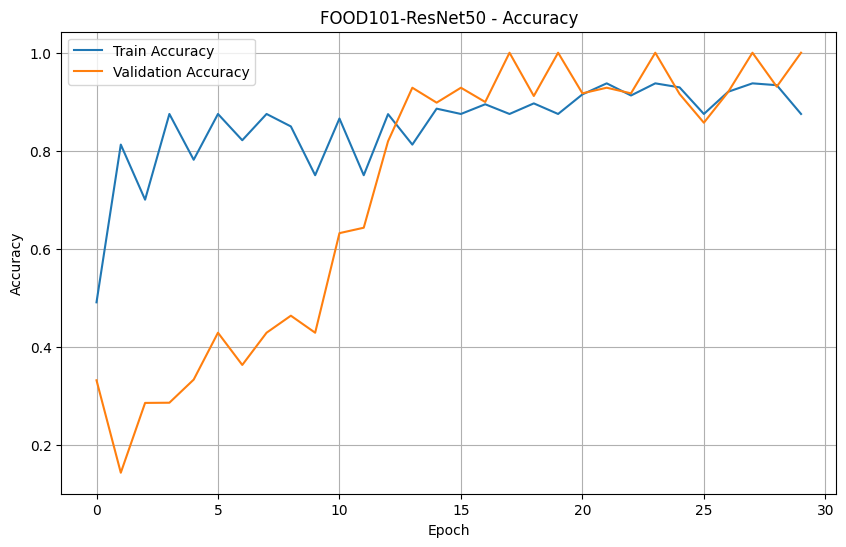

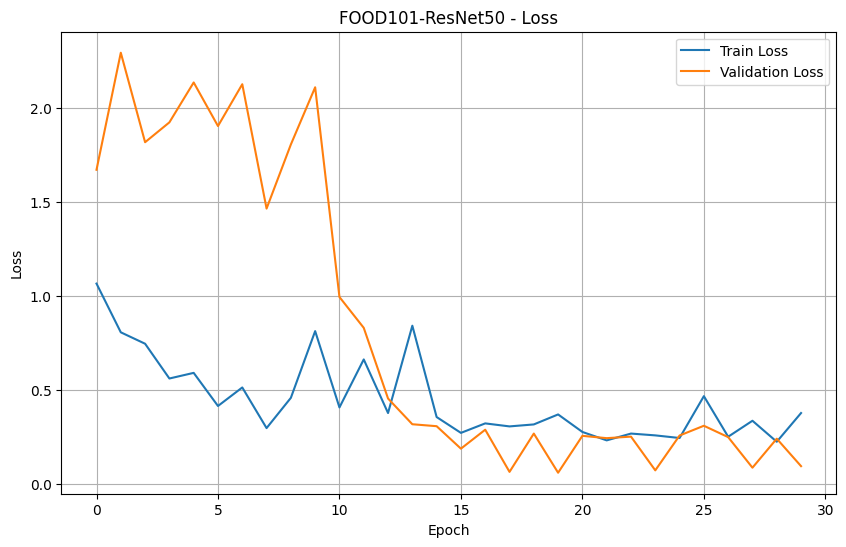

In [23]:
import matplotlib.pyplot as plt

print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")
# Helper function to plot accuracy
def plot_accuracy(history, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(history.history['accuracy'], label='Train Accuracy')  # Changed 'acc' to 'accuracy'
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Changed 'val_acc' to 'val_accuracy'
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Helper function to plot loss
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot the results
plot_accuracy(history, 'FOOD101-ResNet50 - Accuracy')
plot_loss(history, 'FOOD101-ResNet50 - Loss')

# Predicting classes for new images from internet using the best trained model

--2024-12-14 08:33:47--  https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::ac40:93a0, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81352 (79K) [binary/octet-stream]
Saving to: ‘applepie.jpg’

applepie.jpg        100%[===================>]  79.45K  --.-KB/s    in 0.004s  

2024-12-14 08:33:47 (19.8 MB/s) - ‘applepie.jpg’ saved [81352/81352]

--2024-12-14 08:33:47--  https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg?w=2000
Resolving img.freepik.com (img.freepik.com)... 23.54.155.168, 23.54.155.165, 2600:1413:5000:25::1738:6124, ...
Connecting to img.freepik.com (img.freepik.com)|23.54.155.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1143233 (1.1M) [image/jpeg]
Savin

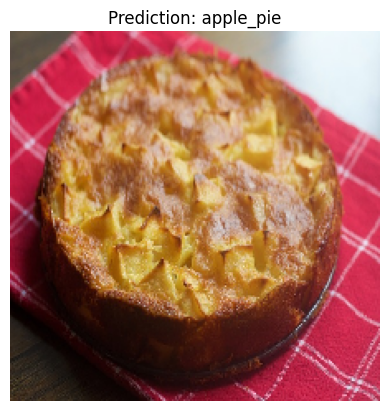

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


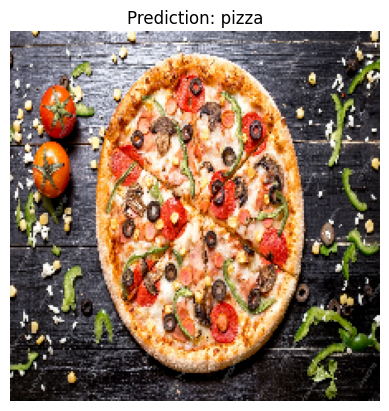

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


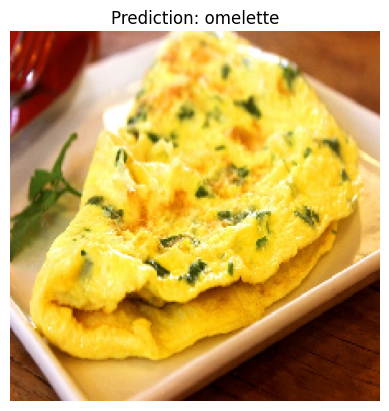

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K

# Clear any previous session
K.clear_session()

# Load the best saved model in .keras format
model_best = load_model('/content/best_model_3class.keras', compile=False)

# Helper function to predict class
def predict_class(model, images, food_list, show=True):
    """
    Predict the class of given images using the trained model.

    Args:
        model: Trained Keras model.
        images: List of image file paths.
        food_list: List of food class names.
        show: Whether to display the image along with the prediction.

    Returns:
        None
    """
    food_list.sort()  # Sort class names to ensure index alignment
    for img_path in images:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize the image pixels to [0, 1]

        # Make predictions
        pred = model.predict(img_array)
        index = np.argmax(pred)  # Get the class index
        pred_value = food_list[index]  # Get the class name

        # Display the image and prediction
        if show:
            plt.imshow(img_array[0])
            plt.axis('off')
            plt.title(f"Prediction: {pred_value}")
            plt.show()

# Download images using wget
!wget -O applepie.jpg https://cdn.pixabay.com/photo/2015/12/01/08/13/apple-pie-1071747_640.jpg
!wget -O pizza.jpg https://img.freepik.com/free-photo/top-view-pepperoni-pizza-with-mushroom-sausages-bell-pepper-olive-corn-black-wooden_141793-2158.jpg?w=2000
!wget -O omelette.jpg https://cdn.pixabay.com/photo/2015/05/20/16/11/kitchen-775746_640.jpg

# List of food classes (sorted in the same order as during training)
food_list = ['apple_pie', 'omelette', 'pizza']

# Make a list of downloaded images and test the trained model
images = ['applepie.jpg', 'pizza.jpg', 'omelette.jpg']
predict_class(model_best, images, food_list, True)

# Fine tune ResNet50 model with 11 classes of data

In [20]:
import os
import random
import numpy as np
from shutil import rmtree, copytree
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K

# Helper function to pick n random food classes
def pick_n_random_classes(n, foods_sorted):
    food_list = []
    random_food_indices = random.sample(range(len(foods_sorted)), n)  # Randomly pick n classes
    for i in random_food_indices:
        food_list.append(foods_sorted[i])
    food_list.sort()  # Sort the selected classes
    return food_list

# Helper function to create data subsets
def dataset_mini(food_list, src, dest):
    """
    Creates a subset of the dataset with the specified classes.

    Args:
        food_list (list): List of food class names.
        src (str): Source directory with the full dataset.
        dest (str): Destination directory for the subset.

    Returns:
        None
    """
    if os.path.exists(dest):
        rmtree(dest)  # Remove existing folder
    os.makedirs(dest)  # Create new folder
    for food_item in food_list:
        print(f"Copying images into {food_item}")
        copytree(os.path.join(src, food_item), os.path.join(dest, food_item))

# Specify data paths and food list
foods_sorted = sorted(os.listdir('/content/food-101/images'))  # List of all food classes
n = 11
food_list = pick_n_random_classes(n, foods_sorted)
print("These are the randomly picked food classes we will be training the model on:\n", food_list)

# Paths for train and test data
src_train = '/content/train'
dest_train = '/content/train_mini_11'  # Save the extracted training images to this folder
src_test = '/content/test'
dest_test = '/content/test_mini_11'  # Save the extracted testing images to this folder

# Create training and testing data folders with new classes
print("Creating training data folder with new classes...")
dataset_mini(food_list, src_train, dest_train)

print("Total number of samples in train folder:")
train_count = sum(len(files) for _, _, files in os.walk(dest_train))
print(train_count)

print("Creating test data folder with new classes...")
dataset_mini(food_list, src_test, dest_test)

print("Total number of samples in test folder:")
test_count = sum(len(files) for _, _, files in os.walk(dest_test))
print(test_count)

# Clear session and define model parameters
K.clear_session()
n_classes = n
img_width, img_height = 224, 224
train_data_dir = '/content/train_mini_11'  # Use new folder for training
validation_data_dir = '/content/test_mini_11'  # Use new folder for validation
nb_train_samples = 8250
nb_validation_samples = 2750
batch_size = 16

# Image data generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load pre-trained ResNet50 and add custom layers
resnet50 = ResNet50(weights='imagenet', include_top=False)
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

# Final output layer for n_classes
predictions = Dense(n_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

# Define the model
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),  # Updated for TensorFlow 2.x
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpointer = ModelCheckpoint(
    filepath='/content/best_model_11class.keras',  # Save as .keras
    verbose=1,
    save_best_only=True
)
csv_logger = CSVLogger('/content/history_11class.log')

# Train the model
history_11class = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    epochs=30,
    verbose=1,
    callbacks=[csv_logger, checkpointer]
)

# Save the final model
model.save('/content/model_trained_11class.keras')

# Display class mapping
class_map_11 = train_generator.class_indices
print("Class Mapping:", class_map_11)

These are the randomly picked food classes we will be training the model on:
 ['carrot_cake', 'chicken_curry', 'chicken_quesadilla', 'club_sandwich', 'cup_cakes', 'deviled_eggs', 'french_onion_soup', 'garlic_bread', 'pad_thai', 'pizza', 'waffles']
Creating training data folder with new classes...
Copying images into carrot_cake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into club_sandwich
Copying images into cup_cakes
Copying images into deviled_eggs
Copying images into french_onion_soup
Copying images into garlic_bread
Copying images into pad_thai
Copying images into pizza
Copying images into waffles
Total number of samples in train folder:
8250
Creating test data folder with new classes...
Copying images into carrot_cake
Copying images into chicken_curry
Copying images into chicken_quesadilla
Copying images into club_sandwich
Copying images into cup_cakes
Copying images into deviled_eggs
Copying images into french_onion_soup
Copying images

# Visualize the accuracy and loss plots for 11 classes

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8571
Final Training Loss: 0.1413
Final Validation Loss: 0.3172


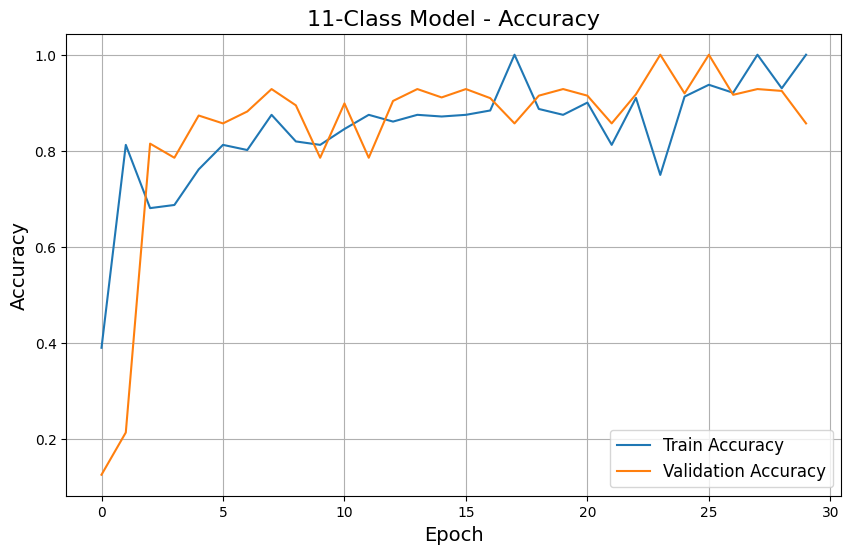

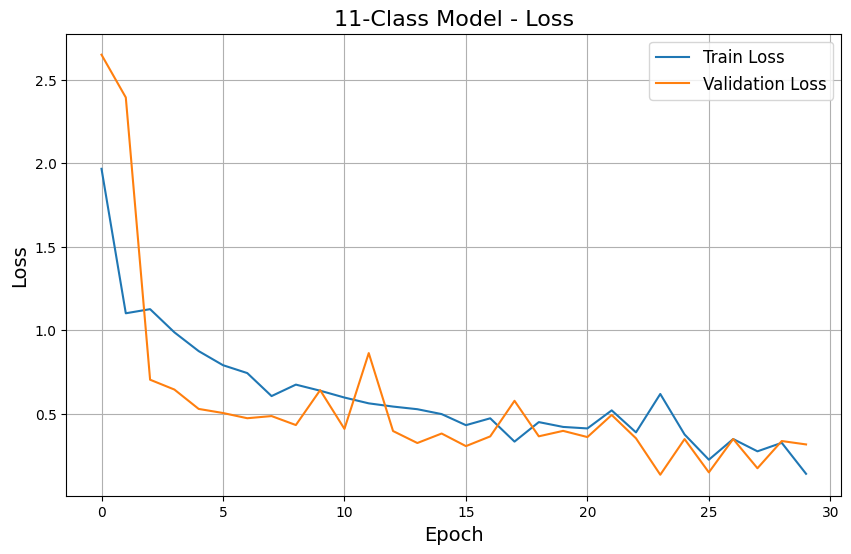

In [22]:
import matplotlib.pyplot as plt

# Extract the final accuracy and loss values for training and validation
final_train_accuracy = history_11class.history['accuracy'][-1]
final_val_accuracy = history_11class.history['val_accuracy'][-1]
final_train_loss = history_11class.history['loss'][-1]
final_val_loss = history_11class.history['val_loss'][-1]

# Print the results
print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

# Plot accuracy graph
def plot_accuracy(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{title} - Accuracy', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.show()

# Plot loss graph
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Loss', fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.show()

# Plot the graphs
plot_accuracy(history_11class, "11-Class Model")
plot_loss(history_11class, "11-Class Model")

# Predicting classes for new images from internet using the best trained model of 11 classes

--2024-12-14 08:55:36--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 104.20.122.60, 172.67.1.236, 104.20.123.60, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|104.20.122.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48618 (47K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  47.48K  --.-KB/s    in 0.001s  

2024-12-14 08:55:36 (35.4 MB/s) - ‘cupcakes.jpg’ saved [48618/48618]

--2024-12-14 08:55:36--  https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1
Resolving c1.staticflickr.com (c1.staticflickr.com)... 108.158.0.70, 2600:9000:2753:4e00:0:5a51:64c9:c681, 2600:9000:2753:c00:0:5a51:64c9:c681, ...
Connecting to c1.staticflickr.com (c1.staticflickr.com)|108.158.0.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/

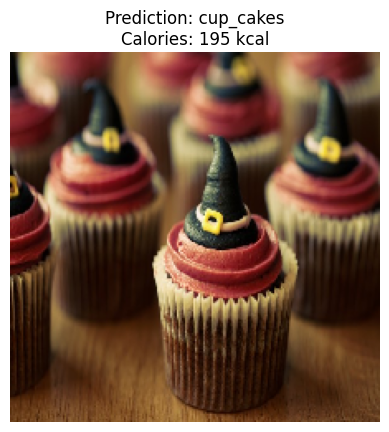

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


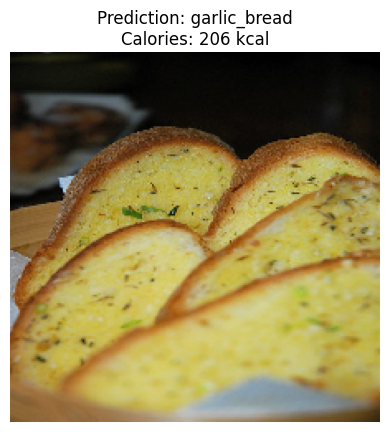

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


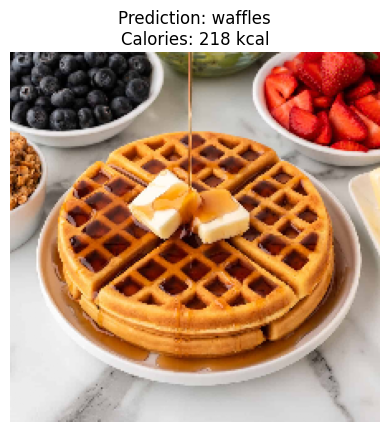

In [30]:
# Import necessary libraries
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Clear previous session
K.clear_session()

# Load the best saved model in .keras format
model_best = load_model('/content/best_model_11class.keras', compile=False)

# Load the CSV file with food calorie information
csv_file_path = '/content/food_calories.csv'
calorie_data = pd.read_csv(csv_file_path)

# Create a dictionary mapping food class names to their calorie values
calorie_dict = dict(zip(calorie_data['Food'], calorie_data['Calories (kcal)']))

# Helper function to predict class and calories
def predict_class_and_calories(model, images, food_list, calorie_dict, show=True):
    """
    Predict the class of given images using the trained model and display calories.

    Args:
        model: Trained Keras model.
        images: List of image file paths.
        food_list: List of food class names.
        calorie_dict: Dictionary mapping food classes to calories.
        show: Whether to display the image along with the prediction and calories.

    Returns:
        None
    """
    food_list.sort()  # Sort class names to ensure index alignment
    for img_path in images:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize the image pixels to [0, 1]

        # Make predictions
        pred = model.predict(img_array)
        index = np.argmax(pred)  # Get the class index
        pred_value = food_list[index]  # Get the class name
        calories = calorie_dict.get(pred_value, "Unknown")  # Get calorie value

        # Display the image, prediction, and calorie value
        if show:
            plt.imshow(img_array[0])
            plt.axis('off')
            plt.title(f"Prediction: {pred_value}\nCalories: {calories} kcal")
            plt.show()

# Downloading images from the internet using the URLs
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1
!wget -O waffles.jpg https://www.designeatrepeat.com/wp-content/uploads/2023/05/best-crispy-belgian-waffles-syrup.jpg

# Note: If you have an image in your local computer and want to try it, uncomment the code below to upload image files.
# from google.colab import files
# uploaded = files.upload()

# List of food classes used in the trained model
food_list = ['carrot_cake', 'chicken_curry', 'chicken_quesadilla', 'club_sandwich',
             'cup_cakes', 'deviled_eggs', 'french_onion_soup', 'garlic_bread',
             'pad_thai', 'pizza', 'waffles']

# Make a list of downloaded images and test the trained model
images = []
images.append('cupcakes.jpg')
images.append('garlicbread.jpg')
images.append('waffles.jpg')
predict_class_and_calories(model_best, images, food_list, calorie_dict, True)

# Change to the Colab working directory
os.chdir("/content")

# Fine tune ResNet50 model with 101 classes of data

In [32]:
import os
import tensorflow as tf
from shutil import rmtree, copytree
import numpy as np
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from tensorflow.keras import backend as tf_backend

def setup_dataset(source_directory, destination_directory):

    if os.path.exists(destination_directory):
        rmtree(destination_directory)
    os.makedirs(destination_directory)

    for food_category in sorted(os.listdir(source_directory)):
        print(f"Copying data for: {food_category}")
        copytree(os.path.join(source_directory, food_category), os.path.join(destination_directory, food_category))

dataset_source_path = '/content/food-101/images'
training_dataset_path = '/content/training_data_full'
validation_dataset_path = '/content/validation_data_full'

print("Preparing the training dataset...")
setup_dataset(dataset_source_path, training_dataset_path)

print("Preparing the validation dataset...")
setup_dataset(dataset_source_path, validation_dataset_path)

training_image_total = sum(len(files) for _, _, files in os.walk(training_dataset_path))
print(f"Total training images: {training_image_total}")

validation_image_total = sum(len(files) for _, _, files in os.walk(validation_dataset_path))
print(f"Total validation images: {validation_image_total}")

tf_backend.clear_session()
total_classes = 101
input_image_dimensions = (224, 224)
batch_size_for_training = 32

training_data_augmentation = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_data_augmentation = ImageDataGenerator(rescale=1.0 / 255)

training_data_generator = training_data_augmentation.flow_from_directory(
    training_dataset_path,
    target_size=input_image_dimensions,
    batch_size=batch_size_for_training,
    class_mode='categorical'
)

validation_data_generator = validation_data_augmentation.flow_from_directory(
    validation_dataset_path,
    target_size=input_image_dimensions,
    batch_size=batch_size_for_training,
    class_mode='categorical'
)

resnet_model = ResNet50(weights='imagenet', include_top=False)
model_output = resnet_model.output
model_output = GlobalAveragePooling2D()(model_output)
model_output = Dense(256, activation='relu')(model_output)
model_output = Dropout(0.3)(model_output)

final_layer_predictions = Dense(total_classes, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(model_output)

final_training_model = Model(inputs=resnet_model.input, outputs=final_layer_predictions)

final_training_model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

best_model_saver = ModelCheckpoint(
    filepath='/content/best_model_for_all_classes.keras',
    verbose=1,
    save_best_only=True
)

training_log_saver = CSVLogger('/content/training_progress_for_all_classes.log')

training_results = final_training_model.fit(
    training_data_generator,
    steps_per_epoch=training_image_total // batch_size_for_training,
    validation_data=validation_data_generator,
    validation_steps=validation_image_total // batch_size_for_training,
    epochs=20,
    verbose=1,
    callbacks=[best_model_saver, training_log_saver]
)

final_training_model.save('/content/final_trained_model_for_all_classes.keras')

food_class_mapping = training_data_generator.class_indices
print("Class Mapping:", food_class_mapping)

Preparing the training dataset...
Copying data for: apple_pie
Copying data for: baby_back_ribs
Copying data for: baklava
Copying data for: beef_carpaccio
Copying data for: beef_tartare
Copying data for: beet_salad
Copying data for: beignets
Copying data for: bibimbap
Copying data for: bread_pudding
Copying data for: breakfast_burrito
Copying data for: bruschetta
Copying data for: caesar_salad
Copying data for: cannoli
Copying data for: caprese_salad
Copying data for: carrot_cake
Copying data for: ceviche
Copying data for: cheese_plate
Copying data for: cheesecake
Copying data for: chicken_curry
Copying data for: chicken_quesadilla
Copying data for: chicken_wings
Copying data for: chocolate_cake
Copying data for: chocolate_mousse
Copying data for: churros
Copying data for: clam_chowder
Copying data for: club_sandwich
Copying data for: crab_cakes
Copying data for: creme_brulee
Copying data for: croque_madame
Copying data for: cup_cakes
Copying data for: deviled_eggs
Copying data for: don

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 3.81884
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.2188 - loss: 4.2887 - val_accuracy: 0.1250 - val_loss: 4.2939
Epoch 3/20
3155/3156 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.2828 - loss: 3.8277
Epoch 3: val_loss improved from 3.81884 to 2.71582, saving model to /content/best_model_for_all_classes.keras
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 1347s 426ms/step - accuracy: 0.2828 - loss: 3.8275 - val_accuracy: 0.5069 - val_loss: 2.7158
Epoch 4/20
   1/3156 ━━━━━━━━━━━━━━━━━━━━ 2:46 53ms/step - accuracy: 0.5312 - loss: 2.7086
Epoch 4: val_loss improved from 2.71582 to 2.44117, saving model to /content/best_model_for_all_classes.keras
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 1s 400us/step - accuracy: 0.5312 - loss: 2.7086 - val_accuracy: 0.5000 - val_loss: 2.4412
Epoch 5/20
3156/3156 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.4344 - loss: 2.9873
Epoch 5: val_loss improved from 2.44117 to 2.30234, saving model to /content/best_model_for_all_c

Final Training Accuracy: 0.6875
Final Validation Accuracy: 0.8750


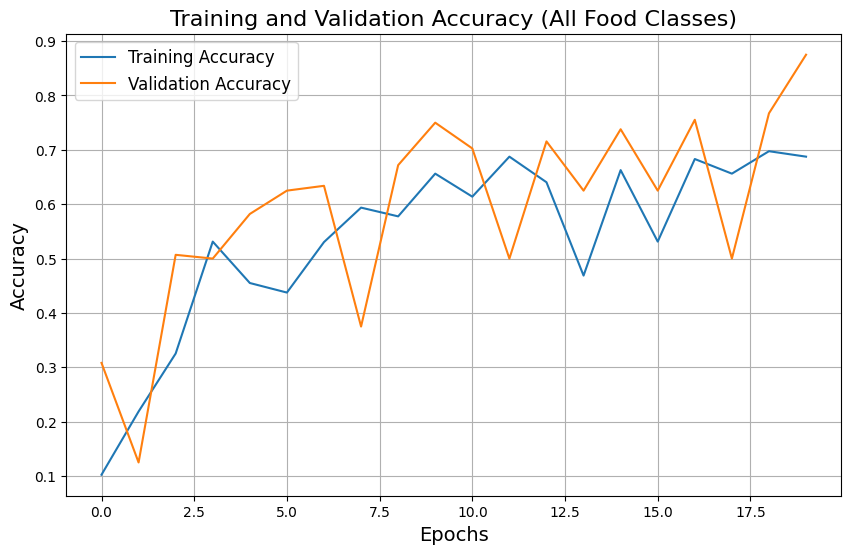

Final Training Loss: 1.7067
Final Validation Loss: 0.9006


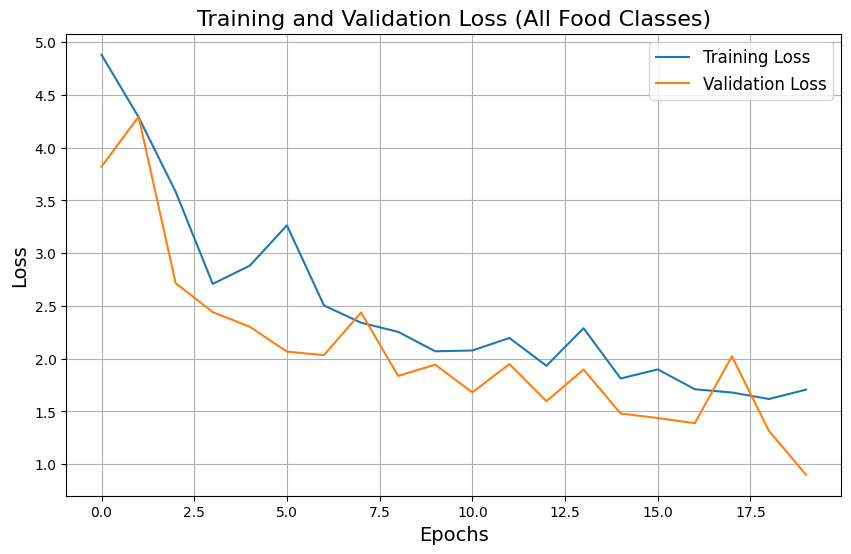

In [34]:
import matplotlib.pyplot as plt

# Function to plot accuracy and print values
def plot_accuracy(history, title='Accuracy Curve'):
    """
    Plots training and validation accuracy over epochs and prints the final values.

    Args:
        history: Training history object from model.fit().
        title: Title of the plot.
    """
    # Extract final accuracy values
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"Final Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.show()

# Function to plot loss and print values
def plot_loss(history, title='Loss Curve'):
    """
    Plots training and validation loss over epochs and prints the final values.

    Args:
        history: Training history object from model.fit().
        title: Title of the plot.
    """
    # Extract final loss values
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]

    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title, fontsize=16)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(True)
    plt.show()

# Assuming the training history object is stored in `training_results`
plot_accuracy(training_results, title='Training and Validation Accuracy (All Food Classes)')
plot_loss(training_results, title='Training and Validation Loss (All Food Classes)')

In [35]:
from sklearn.metrics import classification_report
import numpy as np

# Get true labels and predictions
y_true = validation_generator.classes  # True labels
y_pred = np.argmax(model.predict(validation_generator), axis=1)  # Predicted labels

# Generate classification report
class_names = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:")
print(report)

172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step
Classification Report:
                    precision    recall  f1-score   support

       carrot_cake       0.07      0.06      0.06       250
     chicken_curry       0.06      0.06      0.06       250
chicken_quesadilla       0.10      0.10      0.10       250
     club_sandwich       0.08      0.08      0.08       250
         cup_cakes       0.09      0.09      0.09       250
      deviled_eggs       0.08      0.08      0.08       250
 french_onion_soup       0.09      0.10      0.10       250
      garlic_bread       0.08      0.08      0.08       250
          pad_thai       0.09      0.09      0.09       250
             pizza       0.07      0.07      0.07       250
           waffles       0.10      0.10      0.10       250

          accuracy                           0.08      2750
         macro avg       0.08      0.08      0.08      2750
      weighted avg       0.08      0.08      0.08      2750



In [36]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[16 24 25 23 17 16 20 27 27 31 24]
 [28 16 27 28 15 22 23 22 22 29 18]
 [25 24 24 15 31 22 23 21 18 23 24]
 [17 25 13 20 28 25 25 20 31 22 24]
 [23 30 20 16 22 30 22 32 14 17 24]
 [16 25 18 23 21 20 27 23 21 28 28]
 [28 22 20 20 19 27 24 26 18 25 21]
 [31 19 29 28 24 20 14 20 21 16 28]
 [17 28 22 23 27 22 23 22 23 20 23]
 [24 24 22 21 22 15 29 20 32 18 23]
 [19 20 21 24 31 20 23 21 19 26 26]]


In [38]:
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow.keras.utils import to_categorical  # Import to_categorical

# Top-3 accuracy
top_3_accuracy = TopKCategoricalAccuracy(k=3)

# Convert validation_generator.classes to one-hot encoding
y_true = to_categorical(validation_generator.classes, num_classes=101)

# Update state with one-hot encoded labels and predictions
predictions = model.predict(validation_generator)
top_3_accuracy.update_state(y_true, predictions)

print(f"Top-3 Accuracy: {top_3_accuracy.result().numpy():.4f}")

172/172 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
Top-3 Accuracy: 0.2716


In [42]:
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical

# Get true labels (assuming y_true is already defined)
y_true = validation_generator.classes

# Ensure predictions are in 2D (assuming y_prob is already defined)
y_prob = np.array(y_prob)

# Ensure true labels are one-hot encoded and 2D
y_true_one_hot = to_categorical(y_true, num_classes=len(class_names))  # Correct one-hot encoding

# Compute ROC-AUC score (one-vs-rest)
roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr', average='macro')  # Use y_true directly
print(f"ROC-AUC Score: {roc_auc:.4f}")

ROC-AUC Score: 0.5033


In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.show()

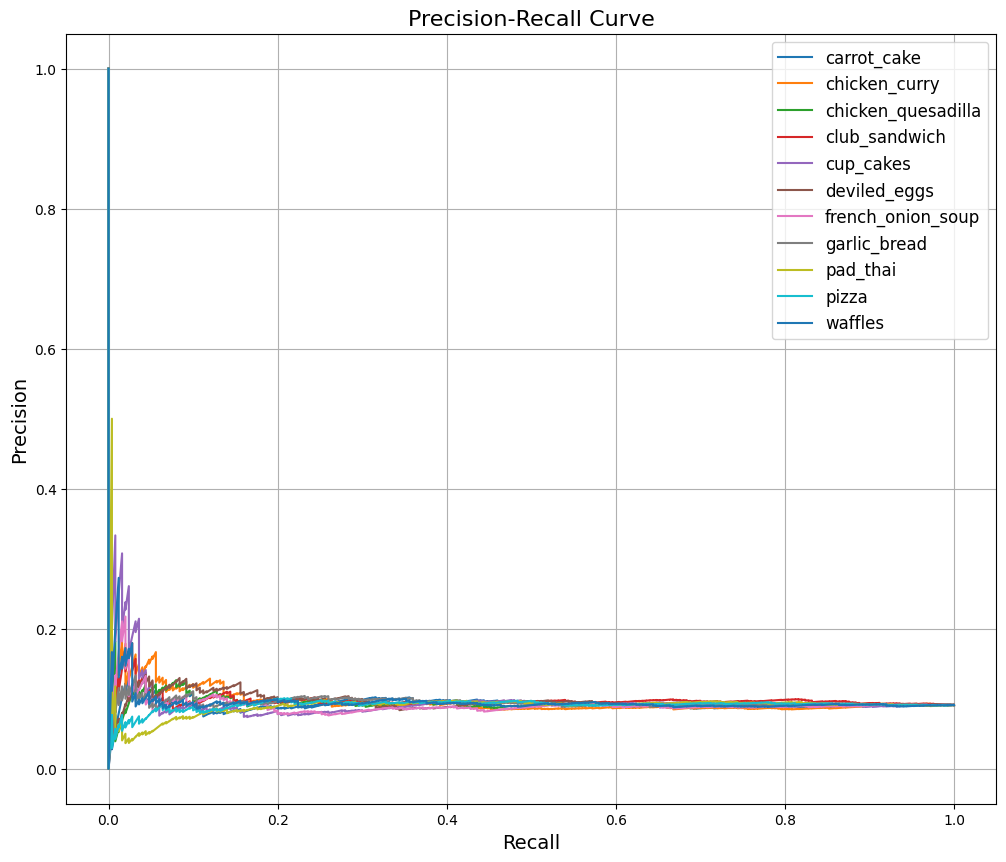

In [44]:
from sklearn.metrics import precision_recall_curve

# Plot Precision-Recall Curve
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(
        np.eye(len(class_names))[y_true][:, i], y_prob[:, i]
    )
    plt.plot(recall, precision, label=f'{class_name}')
plt.title("Precision-Recall Curve", fontsize=16)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

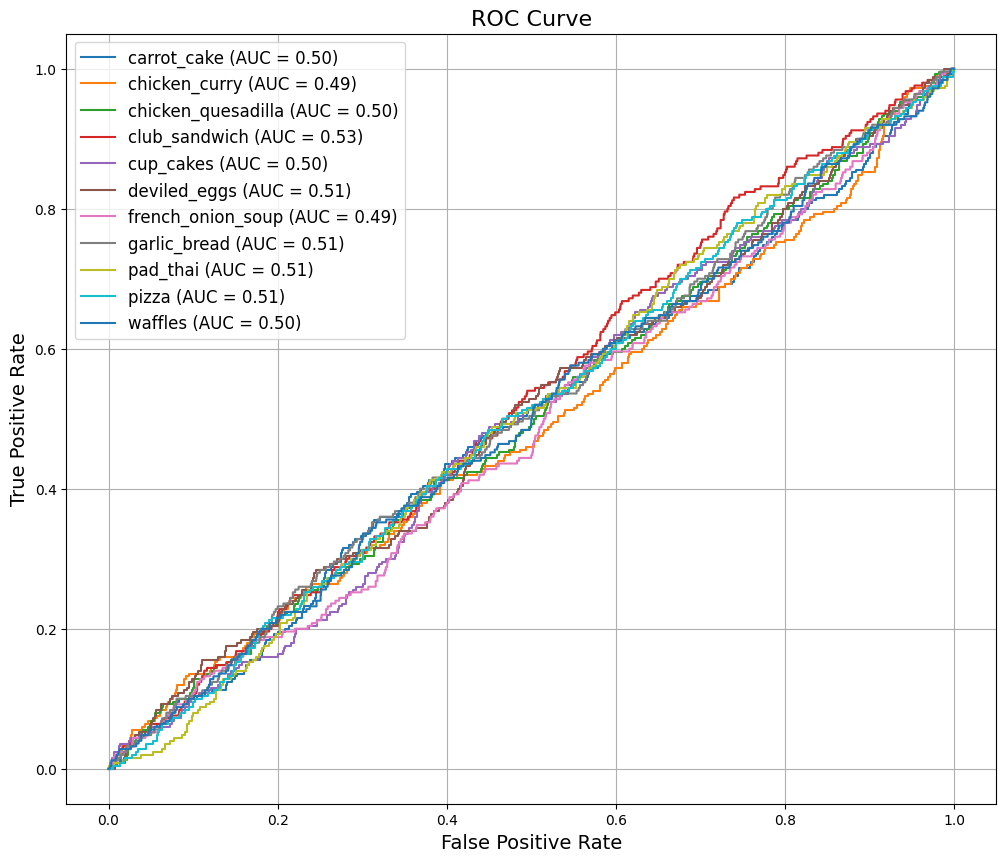

In [46]:
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve
plt.figure(figsize=(12, 10))
for i, class_name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(np.eye(len(class_names))[y_true][:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc(fpr, tpr):.2f})')
plt.title("ROC Curve", fontsize=16)
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(True)
plt.show()

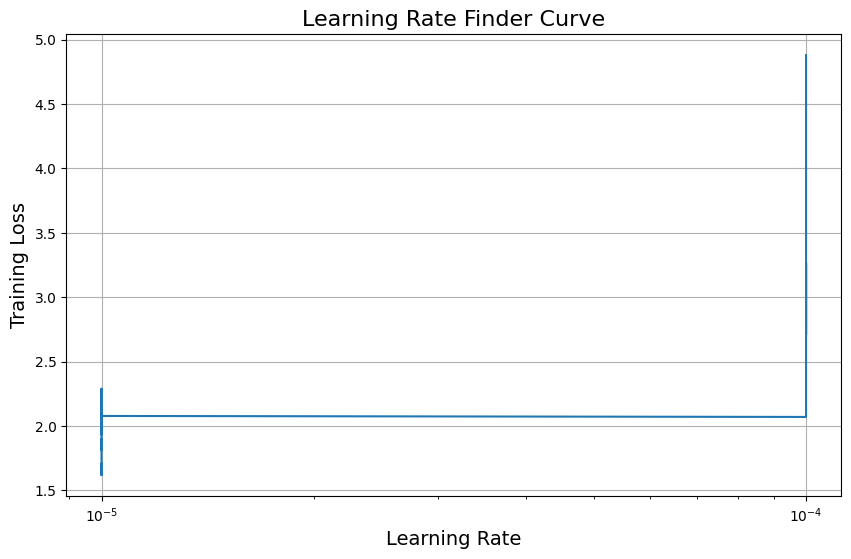

In [47]:
# Example: Visualize learning rate vs loss if you used a scheduler
learning_rates = [0.0001 * (0.1 ** (epoch // 10)) for epoch in range(len(training_results.history['loss']))]

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, training_results.history['loss'])
plt.title("Learning Rate Finder Curve", fontsize=16)
plt.xlabel("Learning Rate", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.xscale("log")
plt.grid(True)
plt.show()

# Predicting classes for new images from internet using the best trained model of 101 classes

--2024-12-14 13:57:03--  https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
Resolving www.publicdomainpictures.net (www.publicdomainpictures.net)... 104.20.122.60, 172.67.1.236, 104.20.123.60, ...
Connecting to www.publicdomainpictures.net (www.publicdomainpictures.net)|104.20.122.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48618 (47K) [image/jpeg]
Saving to: ‘cupcakes.jpg’

cupcakes.jpg        100%[===================>]  47.48K  --.-KB/s    in 0.001s  

2024-12-14 13:57:03 (41.0 MB/s) - ‘cupcakes.jpg’ saved [48618/48618]

--2024-12-14 13:57:03--  https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1
Resolving c1.staticflickr.com (c1.staticflickr.com)... 108.158.0.70, 2600:9000:2753:6a00:0:5a51:64c9:c681, 2600:9000:2753:b800:0:5a51:64c9:c681, ...
Connecting to c1.staticflickr.com (c1.staticflickr.com)|108.158.0.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image

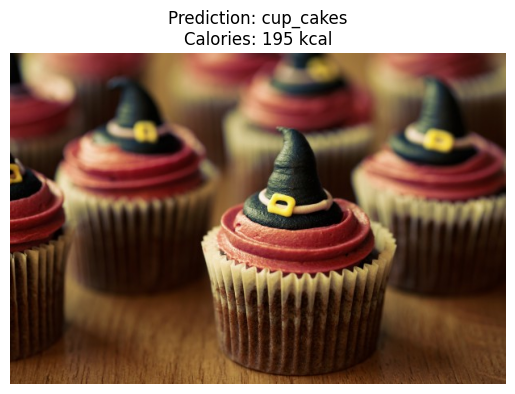

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


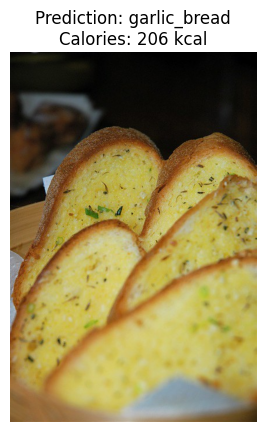

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


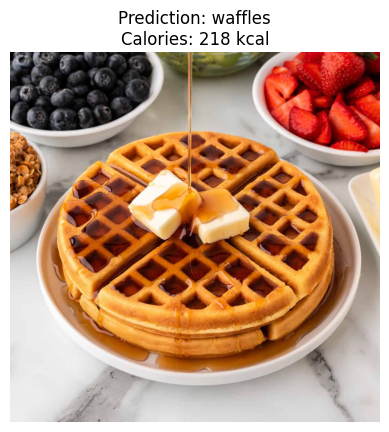

In [51]:
# Import necessary libraries
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

# Clear previous session
K.clear_session()

# Load the best saved model in .keras format
model_best = load_model('/content/best_model_for_all_classes.keras', compile=False)

# Load the CSV file with food calorie information
csv_file_path = '/content/food_calories.csv'
calorie_data = pd.read_csv(csv_file_path)

# Create a dictionary mapping food class names to their calorie values
calorie_dict = dict(zip(calorie_data['Food'], calorie_data['Calories (kcal)']))

# Extract the class mapping from the model or dataset
class_mapping = {
    'apple_pie': 0, 'baby_back_ribs': 1, 'baklava': 2, 'beef_carpaccio': 3, 'beef_tartare': 4,
    'beet_salad': 5, 'beignets': 6, 'bibimbap': 7, 'bread_pudding': 8, 'breakfast_burrito': 9,
    'bruschetta': 10, 'caesar_salad': 11, 'cannoli': 12, 'caprese_salad': 13, 'carrot_cake': 14,
    'ceviche': 15, 'cheese_plate': 16, 'cheesecake': 17, 'chicken_curry': 18, 'chicken_quesadilla': 19,
    'chicken_wings': 20, 'chocolate_cake': 21, 'chocolate_mousse': 22, 'churros': 23, 'clam_chowder': 24,
    'club_sandwich': 25, 'crab_cakes': 26, 'creme_brulee': 27, 'croque_madame': 28, 'cup_cakes': 29,
    'deviled_eggs': 30, 'donuts': 31, 'dumplings': 32, 'edamame': 33, 'eggs_benedict': 34,
    'escargots': 35, 'falafel': 36, 'filet_mignon': 37, 'fish_and_chips': 38, 'foie_gras': 39,
    'french_fries': 40, 'french_onion_soup': 41, 'french_toast': 42, 'fried_calamari': 43,
    'fried_rice': 44, 'frozen_yogurt': 45, 'garlic_bread': 46, 'gnocchi': 47, 'greek_salad': 48,
    'grilled_cheese_sandwich': 49, 'grilled_salmon': 50, 'guacamole': 51, 'gyoza': 52,
    'hamburger': 53, 'hot_and_sour_soup': 54, 'hot_dog': 55, 'huevos_rancheros': 56, 'hummus': 57,
    'ice_cream': 58, 'lasagna': 59, 'lobster_bisque': 60, 'lobster_roll_sandwich': 61,
    'macaroni_and_cheese': 62, 'macarons': 63, 'miso_soup': 64, 'mussels': 65, 'nachos': 66,
    'omelette': 67, 'onion_rings': 68, 'oysters': 69, 'pad_thai': 70, 'paella': 71, 'pancakes': 72,
    'panna_cotta': 73, 'peking_duck': 74, 'pho': 75, 'pizza': 76, 'pork_chop': 77, 'poutine': 78,
    'prime_rib': 79, 'pulled_pork_sandwich': 80, 'ramen': 81, 'ravioli': 82, 'red_velvet_cake': 83,
    'risotto': 84, 'samosa': 85, 'sashimi': 86, 'scallops': 87, 'seaweed_salad': 88,
    'shrimp_and_grits': 89, 'spaghetti_bolognese': 90, 'spaghetti_carbonara': 91, 'spring_rolls': 92,
    'steak': 93, 'strawberry_shortcake': 94, 'sushi': 95, 'tacos': 96, 'takoyaki': 97, 'tiramisu': 98,
    'tuna_tartare': 99, 'waffles': 100
}
food_list = sorted(class_mapping.keys())  # Extract food classes dynamically

# Helper function to predict class and calories
def predict_class_and_calories(model, images, food_list, calorie_dict, show=True):
    """
    Predict the class of given images using the trained model and display calories.

    Args:
        model: Trained Keras model.
        images: List of image file paths.
        food_list: List of food class names.
        calorie_dict: Dictionary mapping food classes to calories.
        show: Whether to display the image along with the prediction and calories.

    Returns:
        None
    """
    food_list.sort()  # Sort class names to ensure index alignment
    for img_path in images:
        # Load and preprocess the image
        img = image.load_img(img_path, target_size=(224, 224))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.  # Normalize the image pixels to [0, 1]

        # Make predictions
        pred = model.predict(img_array)
        index = np.argmax(pred)  # Get the class index
        pred_value = food_list[index]  # Get the class name
        calories = calorie_dict.get(pred_value, "Unknown")  # Get calorie value

        # Display the image, prediction, and calorie value
        if show:
            plt.imshow(image.load_img(img_path))  # Show original image
            plt.axis('off')
            plt.title(f"Prediction: {pred_value}\nCalories: {calories} kcal")
            plt.show()

# Downloading example images
!wget -O cupcakes.jpg https://www.publicdomainpictures.net/pictures/110000/nahled/halloween-witch-cupcakes.jpg
!wget -O garlicbread.jpg https://c1.staticflickr.com/1/84/262952165_7ba3466108_z.jpg?zz=1
!wget -O waffles.jpg https://www.designeatrepeat.com/wp-content/uploads/2023/05/best-crispy-belgian-waffles-syrup.jpg


# Test the model with downloaded images
images = ['cupcakes.jpg', 'garlicbread.jpg','waffles.jpg']
predict_class_and_calories(model_best, images, food_list, calorie_dict, True)

# Change to the Colab working directory
os.chdir("/content")

# Accuracy with portion control using bounding boxes (YOLO)

In [56]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load your trained model
classification_model = load_model('/content/best_model_for_all_classes.keras', compile=False)

# Function to classify the food
def classify_food(img_path, model, food_classes):
    """
    Classifies the food image and returns the predicted class.

    Args:
        img_path: Path to the image.
        model: Trained classification model.
        food_classes: List of class names.

    Returns:
        pred_class: Predicted class name.
        pred_confidence: Confidence score for the predicted class.
    """
    # Preprocess the image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions
    predictions = model.predict(img_array)
    class_idx = np.argmax(predictions)
    pred_class = food_classes[class_idx]
    pred_confidence = predictions[0][class_idx]

    return pred_class, pred_confidence

# Example usage
food_classes = sorted([
    'apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare',
    'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito',
    'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake',
    'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla',
    'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder',
    'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes',
    'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict',
    'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras',
    'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari',
    'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad',
    'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza',
    'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus',
    'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich',
    'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos',
    'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes',
    'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine',
    'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake',
    'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad',
    'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls',
    'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu',
    'tuna_tartare', 'waffles'
])

image_path = '/content/pizza.jpg'
pred_class, pred_confidence = classify_food(image_path, classification_model, food_classes)
print(f"Predicted Class: {pred_class}, Confidence: {pred_confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: pizza, Confidence: 0.86


In [54]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 50.9 MB/s eta 0:00:00


In [57]:
from ultralytics import YOLO

# Load YOLOv8 pre-trained model
detection_model = YOLO('yolov8n.pt')  # Replace with a fine-tuned model if available

def get_bounding_box(image_path, model, target_class):
    """
    Detects the bounding box for the target class in the image.

    Args:
        image_path: Path to the input image.
        model: Pre-trained YOLO model.
        target_class: Food class to detect.

    Returns:
        bbox: Bounding box coordinates (x1, y1, x2, y2).
        confidence: Confidence score for the detection.
    """
    # Run YOLOv8 inference
    results = model(image_path)

    for result in results[0].boxes:
        class_id = int(result.cls[0])  # Class index
        confidence = result.conf[0]  # Confidence score

        # Check if the detected class matches the target class
        if model.names[class_id] == target_class:
            x1, y1, x2, y2 = result.xyxy[0]  # Bounding box coordinates
            return (x1, y1, x2, y2), confidence

    return None, 0  # No bounding box found

# Example usage
bbox, confidence = get_bounding_box(image_path, detection_model, pred_class)
if bbox:
    print(f"Bounding Box: {bbox}, Confidence: {confidence:.2f}")
else:
    print("Bounding Box not found for the predicted class.")


image 1/1 /content/pizza.jpg: 448x640 1 pizza, 1 dining table, 9.2ms
Speed: 8.0ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Bounding Box: (tensor(460.7213, device='cuda:0'), tensor(71.7023, device='cuda:0'), tensor(1599.4248, device='cuda:0'), tensor(1226.5814, device='cuda:0')), Confidence: 0.94


In [58]:
def calculate_portion_size(bbox, img_width, img_height):
    """
    Calculates the portion size based on the bounding box.

    Args:
        bbox: Bounding box coordinates (x1, y1, x2, y2).
        img_width: Width of the image.
        img_height: Height of the image.

    Returns:
        portion_size: Portion size as a fraction of the total image area.
    """
    x1, y1, x2, y2 = bbox
    box_area = (x2 - x1) * (y2 - y1)
    img_area = img_width * img_height
    portion_size = box_area / img_area
    return portion_size

# Example usage
img = image.load_img(image_path)
img_width, img_height = img.size
portion_size = calculate_portion_size(bbox, img_width, img_height)
print(f"Portion Size: {portion_size:.2f}")

Portion Size: 0.49


In [59]:
def estimate_calories(base_calories, portion_size):
    """
    Adjusts the calorie estimation based on portion size.

    Args:
        base_calories: Base calorie value for the full portion.
        portion_size: Portion size as a fraction.

    Returns:
        estimated_calories: Adjusted calorie value.
    """
    estimated_calories = base_calories * portion_size
    return estimated_calories

# Example usage
calorie_dict = {'pizza': 285}  # Add all food calorie mappings
base_calories = calorie_dict.get(pred_class, 0)
adjusted_calories = estimate_calories(base_calories, portion_size)
print(f"Adjusted Calories: {adjusted_calories:.2f} kcal")

Adjusted Calories: 140.58 kcal


# Adding segmentation-based portion control